<a href="https://colab.research.google.com/github/felipemoraissoares/BatteryCommunicationSCPI/blob/main/data_embraer_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Embraer - Prophet

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

!pip install prophet
from prophet import Prophet

## Carregamento dos dados

In [ ]:
file_path = "/content/Data Embraer.csv"
df_embraer = pd.read_csv(file_path, sep=";")

In [ ]:
df_embraer.head()

,Family,Aircraft Type,Serial Number,Delivery Date,Reference Date,Operator,Country,Region,Macro-Region,Age (years),Age (months),Status,FH Acc.,FC Acc.
0,ERJ,145,14500003,01/01/2005,31/01/2005,TRANS STATES,USA,North and Central America,North and Central America,1,1,Delivered,7802.0,11205.0
1,ERJ,145,14500003,01/01/2005,28/02/2005,TRANS STATES,USA,North and Central America,North and Central America,1,2,In Service,7978.0,11369.0
2,ERJ,145,14500003,01/01/2005,31/03/2005,TRANS STATES,USA,North and Central America,North and Central America,1,3,In Service,8213.0,11571.0
3,ERJ,145,14500003,01/01/2005,30/04/2005,TRANS STATES,USA,North and Central America,North and Central America,1,4,In Service,8412.0,11762.0
4,ERJ,145,14500003,01/01/2005,31/05/2005,TRANS STATES,USA,North and Central America,North and Central America,1,5,In Service,8613.0,11946.0


## Pré-processamento

In [ ]:
# Renomeando colunas
df_embraer.rename(columns={'Aircraft Type': 'aircraft_type',
                           'Serial Number': 'serial_number',
                           'Delivery Date': 'delivery_date',
                           'Reference Date': 'reference_date',
                           'Age (years)': 'age_years',
                           'Age (months)': 'age_months',
                           'FH Acc.': 'fh_acc',
                           'FC Acc.': 'fc_acc',
                           }, inplace = True)

In [ ]:
# cria colunas datetime para a data de entrega e data de referencia
df_embraer ["delivery_date"] = pd.to_datetime(df_embraer["delivery_date"], format="%d/%m/%Y")
df_embraer ["reference_date"] = pd.to_datetime(df_embraer["reference_date"], format="%d/%m/%Y")

In [ ]:
df_embraer.head()

,Family,aircraft_type,serial_number,delivery_date,reference_date,Operator,Country,Region,Macro-Region,age_years,age_months,Status,fh_acc,fc_acc
0,ERJ,145,14500003,2005-01-01,2005-01-31,TRANS STATES,USA,North and Central America,North and Central America,1,1,Delivered,7802.0,11205.0
1,ERJ,145,14500003,2005-01-01,2005-02-28,TRANS STATES,USA,North and Central America,North and Central America,1,2,In Service,7978.0,11369.0
2,ERJ,145,14500003,2005-01-01,2005-03-31,TRANS STATES,USA,North and Central America,North and Central America,1,3,In Service,8213.0,11571.0
3,ERJ,145,14500003,2005-01-01,2005-04-30,TRANS STATES,USA,North and Central America,North and Central America,1,4,In Service,8412.0,11762.0
4,ERJ,145,14500003,2005-01-01,2005-05-31,TRANS STATES,USA,North and Central America,North and Central America,1,5,In Service,8613.0,11946.0


In [ ]:
# Quantos aviões diferentes a base possui
df_embraer['serial_number'].nunique()

2576

### Agrupamento

In [ ]:
# Realiza o agrupamento em um dataset secundário

df_embraer_group = (
    df_embraer
    .groupby([
        "serial_number", "Family", "aircraft_type", "Country", "Region", "Macro-Region",
        "Status"
    ])
    .agg(
        age_years_min=("age_years", "min"),
        age_years_max=("age_years", "max"),
        age_months_min=("age_months", "min"),
        age_months_max=("age_months", "max"),
        fh_acc_min=("fh_acc", "min"),
        fh_acc_max=("fh_acc", "max"),
        fc_acc_min=("fc_acc", "min"),
        fc_acc_max=("fc_acc", "max"),
        reference_date_min=("reference_date", "min"),
        reference_date_max=("reference_date", "max"),
    )
    .reset_index()
    .sort_values("reference_date_min")
)

In [ ]:
# Somente para auxilio de vizualização
df_teste = df_embraer_group[df_embraer_group["serial_number"] == 14500004]
df_teste.head()

,serial_number,Family,aircraft_type,Country,Region,Macro-Region,Status,age_years_min,age_years_max,age_months_min,age_months_max,fh_acc_min,fh_acc_max,fc_acc_min,fc_acc_max,reference_date_min,reference_date_max
4,14500004,ERJ,145,USA,North and Central America,North and Central America,Delivered,1,1,1,1,0.0,0.0,0.0,0.0,1996-12-31,1996-12-31
5,14500004,ERJ,145,USA,North and Central America,North and Central America,In Service,1,18,2,213,45.0,34311.0,48.0,33179.0,1997-01-31,2014-08-31
7,14500004,ERJ,145,USA,North and Central America,North and Central America,Storage,18,21,214,252,34311.0,34311.0,33180.0,33180.0,2014-09-30,2017-11-30
6,14500004,ERJ,145,USA,North and Central America,North and Central America,Retired,22,26,253,307,NaN,NaN,NaN,NaN,2017-12-31,2022-06-30


In [ ]:
df_teste.dtypes

serial_number                  int64
Family                        object
aircraft_type                  int64
Country                       object
Region                        object
Macro-Region                  object
Status                        object
age_years_min                  int64
age_years_max                  int64
age_months_min                 int64
age_months_max                 int64
fh_acc_min                   float64
fh_acc_max                   float64
fc_acc_min                   float64
fc_acc_max                   float64
reference_date_min    datetime64[ns]
reference_date_max    datetime64[ns]
dtype: object

### Juntando dados por número de série

In [ ]:
# Vai criar uma lista com os números de série individual, colocando as informações necessárias em colunas

aircraft_year = []
serial_aux_list = []

for item in df_embraer_group.itertuples():
  if item.serial_number not in serial_aux_list:
    # Criando as variáveis necessárias para processamento posterior
    serial_number = item.serial_number
    family = item.Family
    aircraft_type = item.aircraft_type

    # Primeiro momento em operação da aeronave
    initial_service = df_embraer_group[(df_embraer_group["serial_number"] == serial_number) & (df_embraer_group["Status"] == 'In Service')]['reference_date_min'].min()

    # maior valor de horas de fc e fh da aeronave
    fh_acc_max = df_embraer_group[df_embraer_group["serial_number"] == serial_number]['fh_acc_max'].max()
    fc_acc_max = df_embraer_group[df_embraer_group["serial_number"] == serial_number]['fc_acc_max'].max()

    # Verificar se aeronave esta aposentada
    # Obtem a última data de referencia
    reference_date_max = df_embraer_group[df_embraer_group["serial_number"] == serial_number]['reference_date_max'].max()
    # obtem o status para a última data de referencia
    status = df_embraer_group[(df_embraer_group["serial_number"] == serial_number) & (df_embraer_group["reference_date_max"] == reference_date_max)]["Status"].iloc[0]

    if status == "Retired":
      retired = 1
      # Areonaves aposentadas continuam contando os anos e meses
      # Se esta aposentada, para pegar os anos de operação do status anterior
      # Como não há certeza do status, uso do for reverso para retornar ao último status antes do Retired **Deve ter um jeito mais bonito de fazer isso :(
      df_aux = df_embraer_group[df_embraer_group["serial_number"] == serial_number]
      for index in reversed(df_aux.index):
        if df_aux.loc[index, 'Status'] != 'Retired':
          operation_years = df_aux.loc[index, 'age_years_max']
          operation_months = df_aux.loc[index, 'age_months_max']
          break
    else:
      retired = 0
      # Se não esta aposentada pegar o maior valor de ano e mes
      operation_years = df_embraer_group[df_embraer_group["serial_number"] == serial_number]['age_years_max'].max()
      operation_months = df_embraer_group[df_embraer_group["serial_number"] == serial_number]['age_months_max'].max()

    # Coloca o serial em uma lista para não repetir a aeronave
    serial_aux_list.append(serial_number)
    # Alimenta a lista por aeronave
    aircraft_year.append([serial_number, family, aircraft_type, initial_service, operation_years, operation_months, fh_acc_max, fc_acc_max, retired])
  else:
    # to do
    pass

In [ ]:
# Cria um dataframe da lista
df_aircraft_year = pd.DataFrame(aircraft_year, columns = ['serial_number', 'family', 'aircraft_type',
                                                          'initial_service', 'operation_years', 'operation_months',
                                                          'fh_acc_max', 'fc_acc_max', 'retired'])

In [ ]:
df_aircraft_year

,serial_number,family,aircraft_type,initial_service,operation_years,operation_months,fh_acc_max,fc_acc_max,retired
0,14500004,ERJ,145,1997-01-31,21,252,34311.0,33180.0,1
1,14500005,ERJ,145,1997-01-31,20,240,34783.0,33957.0,1
2,14500007,ERJ,145,1997-02-28,20,229,34824.0,33228.0,1
3,14500006,ERJ,145,1997-02-28,21,243,34581.0,33289.0,1
4,14500009,ERJ,145,1997-03-31,19,226,34333.0,33052.0,1
...,...,...,...,...,...,...,...,...,...
2571,17000896,E1 170/5,175,2022-05-31,1,7,397.0,242.0,0
2572,17000897,E1 170/5,175,2022-06-30,1,7,235.0,148.0,0
2573,17000898,E1 170/5,175,NaT,1,7,16.0,7.0,0
2574,17000899,E1 170/5,175,NaT,1,7,15.0,7.0,0


In [ ]:
# Coluna Final Date criada, somando a data do serviço incial mais os meses de operação
df_aircraft_year['final_date'] = df_aircraft_year.apply(lambda x: (x['initial_service'] + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)) + pd.DateOffset(months=x['operation_months']), axis=1)

In [ ]:
df_aircraft_year

,serial_number,family,aircraft_type,initial_service,operation_years,operation_months,fh_acc_max,fc_acc_max,retired,final_date
0,14500004,ERJ,145,1997-01-31,21,252,34311.0,33180.0,1,2018-01-01
1,14500005,ERJ,145,1997-01-31,20,240,34783.0,33957.0,1,2017-01-01
2,14500007,ERJ,145,1997-02-28,20,229,34824.0,33228.0,1,2016-03-01
3,14500006,ERJ,145,1997-02-28,21,243,34581.0,33289.0,1,2017-05-01
4,14500009,ERJ,145,1997-03-31,19,226,34333.0,33052.0,1,2016-01-01
...,...,...,...,...,...,...,...,...,...,...
2571,17000896,E1 170/5,175,2022-05-31,1,7,397.0,242.0,0,2022-12-01
2572,17000897,E1 170/5,175,2022-06-30,1,7,235.0,148.0,0,2023-01-01
2573,17000898,E1 170/5,175,NaT,1,7,16.0,7.0,0,NaT
2574,17000899,E1 170/5,175,NaT,1,7,15.0,7.0,0,NaT


In [ ]:
# Cria um dataframe somente com os aposentados
df_aircraft_year_retired = df_aircraft_year.query('retired == 1')

# Cria um dataframe somente com os ativos
df_aircraft_year_operational = df_aircraft_year.query('retired == 0')

In [ ]:
df_aircraft_year_retired

,serial_number,family,aircraft_type,initial_service,operation_years,operation_months,fh_acc_max,fc_acc_max,retired,final_date
0,14500004,ERJ,145,1997-01-31,21,252,34311.0,33180.0,1,2018-01-01
1,14500005,ERJ,145,1997-01-31,20,240,34783.0,33957.0,1,2017-01-01
2,14500007,ERJ,145,1997-02-28,20,229,34824.0,33228.0,1,2016-03-01
3,14500006,ERJ,145,1997-02-28,21,243,34581.0,33289.0,1,2017-05-01
4,14500009,ERJ,145,1997-03-31,19,226,34333.0,33052.0,1,2016-01-01
...,...,...,...,...,...,...,...,...,...,...
1587,17000320,E1 170/5,170,2011-01-31,8,93,11850.0,11400.0,1,2018-10-01
1588,19000367,E1 190/5,190,2011-01-31,7,79,12026.0,9152.0,1,2017-08-01
1603,19000419,E1 190/5,195,2011-04-30,7,74,17890.0,13365.0,1,2017-06-01
1630,19000403,E1 190/5,190,2011-06-30,7,73,11171.0,8622.0,1,2017-07-01


In [ ]:
df_aircraft_year_operational

,serial_number,family,aircraft_type,initial_service,operation_years,operation_months,fh_acc_max,fc_acc_max,retired,final_date
6,14500013,ERJ,145,1997-05-31,26,303,1787.0,1381.0,0,2022-08-01
9,14500008,ERJ,145,1997-06-30,26,302,30148.0,29396.0,0,2022-08-01
10,14500010,ERJ,145,1997-07-31,26,301,36755.0,37323.0,0,2022-08-01
11,14500012,ERJ,145,1997-07-31,26,301,38819.0,38898.0,0,2022-08-01
18,14500025,ERJ,145,1997-10-31,25,298,41009.0,40016.0,0,2022-08-01
...,...,...,...,...,...,...,...,...,...,...
2571,17000896,E1 170/5,175,2022-05-31,1,7,397.0,242.0,0,2022-12-01
2572,17000897,E1 170/5,175,2022-06-30,1,7,235.0,148.0,0,2023-01-01
2573,17000898,E1 170/5,175,NaT,1,7,16.0,7.0,0,NaT
2574,17000899,E1 170/5,175,NaT,1,7,15.0,7.0,0,NaT


In [ ]:
# Salvando a lista em um CSV
df_aircraft_year.to_csv('data_embraer_individual.csv')
df_aircraft_year_retired.to_csv('data_embraer_individual_aposentados.csv')
df_aircraft_year_operational.to_csv('data_embraer_individual_operacionais.csv')

### Transformando dados para processamento de série temporal

In [ ]:
# Criando um range de datas

# De data inicial
start_dt = date(1997, 1, 1)
# Até data final
end_dt = date(2022, 7, 30)

# Lista para salvar as datas no invervalo de tempo
dates = []

while start_dt <= end_dt:
    # Adiciona as datas convertendo para o formato iso
    dates.append(start_dt.isoformat())

    # incrementa a data incial em 1 mês
    start_dt += pd.DateOffset(months=1)

print('Dates between', start_dt, 'and', end_dt)

Dates between 2022-08-01 00:00:00 and 2022-07-30


<ipython-input-30-e5145515dde1>:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while start_dt <= end_dt:


In [ ]:
# Criando datagframe
df_ds = pd.DataFrame(dates, columns=['ds'])

In [ ]:
# Iniciando targets com zero
df_ds['y'] = np.zeros(len(df_ds))

# Formato da data para padrão
df_ds["ds"] = pd.to_datetime(df_ds["ds"], format="%Y/%m/%d")

In [ ]:
# Dataframe para serie temporal de todos os aviões
df_ts_total = df_ds.copy()

# Dataframe para serie temporal de aviões aposentados
df_ts_retired = df_ds.copy()

# Dataframe para serie temporal de aviões em operação
df_ts_operational = df_ds.copy()

In [ ]:
# Alimenta o dataframe do total de aviões

for index in df_ts_total.index:
  # Data a ser comparada
  data_to_compare = df_ts_total.loc[index, 'ds']
  # Quantidade de aviões onde a data a ser comparada esta maior que o serviço inicial e menor que a última data de referência
  df_ts_total.loc[index, 'y'] = len(df_aircraft_year.query('@data_to_compare >= initial_service & @data_to_compare <= final_date'))

In [ ]:
df_ts_total

,ds,y
0,1997-01-01,0.0
1,1997-02-01,2.0
2,1997-03-01,4.0
3,1997-04-01,5.0
4,1997-05-01,5.0
...,...,...
302,2022-03-01,2346.0
303,2022-04-01,2346.0
304,2022-05-01,2347.0
305,2022-06-01,2347.0


In [ ]:
# Alimenta o dataframe de aviões aposentados

for index in df_ts_retired.index:
  # Data a ser comparada
  data_to_compare = df_ts_retired.loc[index, 'ds']
  # Quantidade de aviões onde a data a ser comparada esta maior que o serviço inicial e menor que a última data de referência
  df_ts_retired.loc[index, 'y'] = len(df_aircraft_year_retired.query('@data_to_compare >= initial_service & @data_to_compare <= final_date'))

In [ ]:
df_ts_retired

,ds,y
0,1997-01-01,0.0
1,1997-02-01,2.0
2,1997-03-01,4.0
3,1997-04-01,5.0
4,1997-05-01,5.0
...,...,...
302,2022-03-01,10.0
303,2022-04-01,10.0
304,2022-05-01,10.0
305,2022-06-01,9.0


In [ ]:
# Alimenta o dataframe de aviões operacionais

for index in df_ts_operational.index:
  # Data a ser comparada
  data_to_compare = df_ts_operational.loc[index, 'ds']
  # Quantidade de aviões onde a data a ser comparada esta maior que o serviço inicial e menor que a última data de referência
  df_ts_operational.loc[index, 'y'] = len(df_aircraft_year_operational.query('@data_to_compare >= initial_service & @data_to_compare <= final_date'))

In [ ]:
df_ts_operational

,ds,y
0,1997-01-01,0.0
1,1997-02-01,0.0
2,1997-03-01,0.0
3,1997-04-01,0.0
4,1997-05-01,0.0
...,...,...
302,2022-03-01,2336.0
303,2022-04-01,2336.0
304,2022-05-01,2337.0
305,2022-06-01,2338.0


## Utilização do Prophet

### Visualização dos dados

#### Aeronaves aposentadas

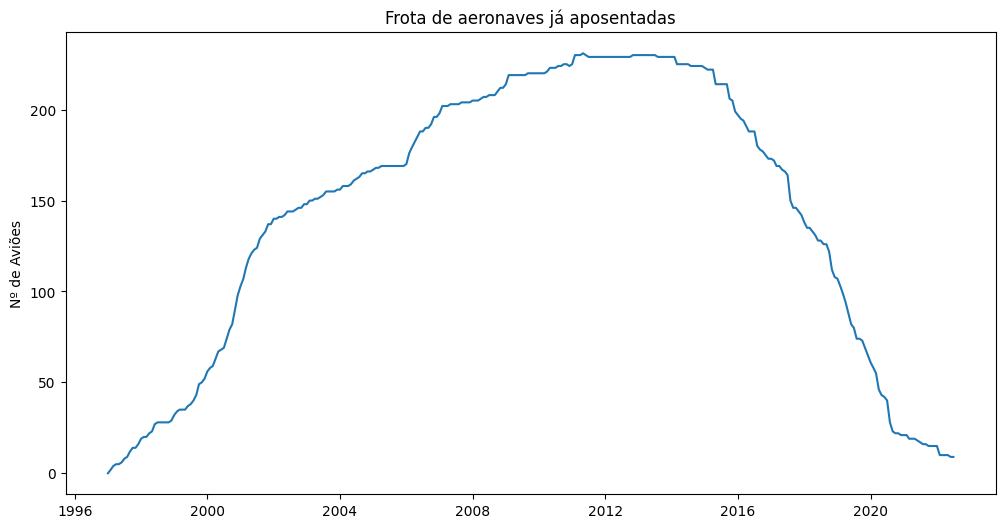

In [ ]:
# Plot para frota de aeronaves aposentadas
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_ts_retired['ds'], df_ts_retired['y'])
plt.ylabel('Nº de Aviões')
plt.title('Frota de aeronaves já aposentadas')
plt.show()

#### Aeronaves em operação

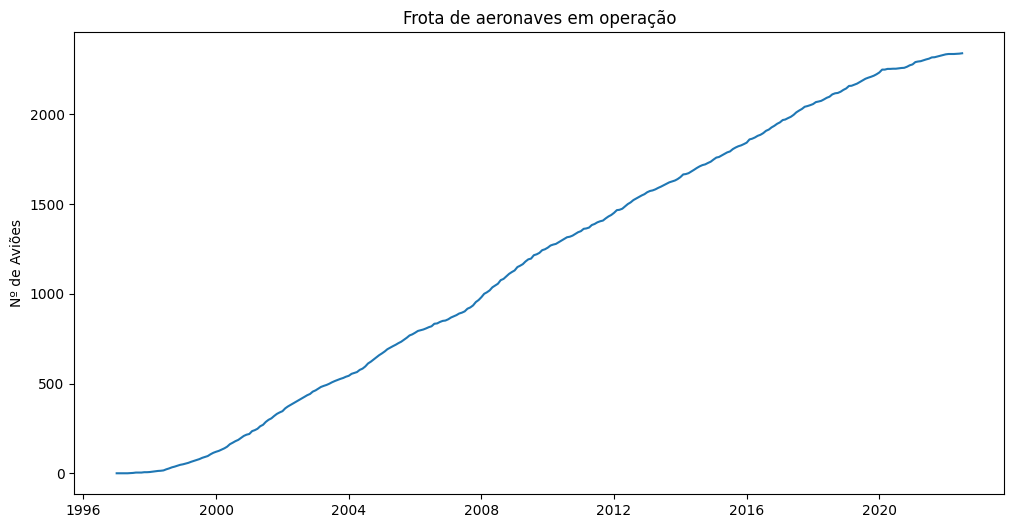

In [ ]:
# Plot para frota de aeronaves aposentadas
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_ts_operational['ds'], df_ts_operational['y'])
plt.ylabel('Nº de Aviões')
plt.title('Frota de aeronaves em operação')
plt.show()

#### Todas as aeronaves

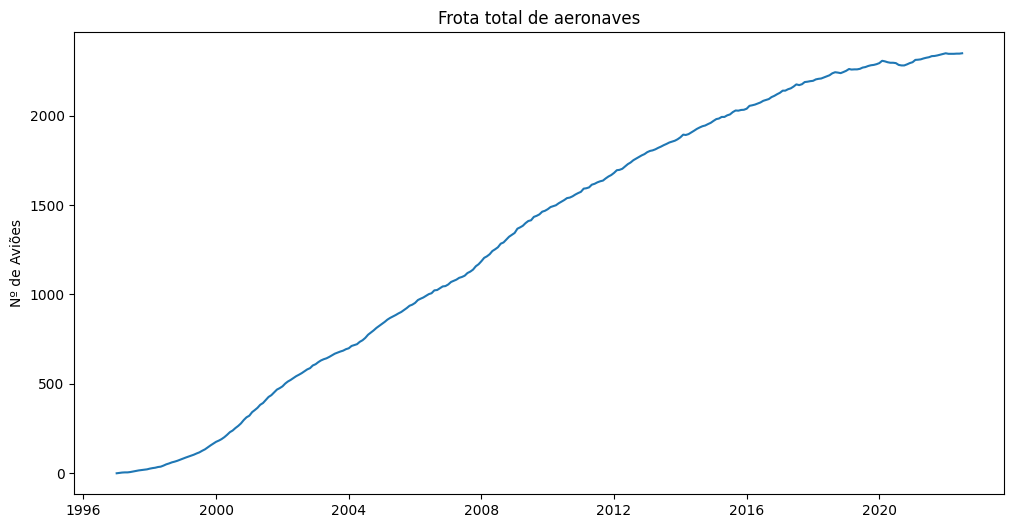

In [ ]:
# Plot para frota de aeronaves aposentadas
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_ts_total['ds'], df_ts_total['y'])
plt.ylabel('Nº de Aviões')
plt.title('Frota total de aeronaves')
plt.show()

### Separação dos dados

In [ ]:
# Divisão para o modelo de aposentados somente
train = df_ts_retired.iloc[:-60]
test = df_ts_retired.iloc[-60:]

### Treinamento

In [ ]:
# Resetando o index
df_ts_retired.reset_index(inplace=True)
df_ts_operational.reset_index(inplace=True)
df_ts_total.reset_index(inplace=True)

#### Primeiro teste

In [ ]:
model_retirement = Prophet()
model_retirement.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_93o9jng/cr9lczyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_93o9jng/6lm5bdbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58149', 'data', 'file=/tmp/tmp_93o9jng/cr9lczyd.json', 'init=/tmp/tmp_93o9jng/6lm5bdbx.json', 'output', 'file=/tmp/tmp_93o9jng/prophet_model8ce98e0z/prophet_model-20230815102958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:29:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:29:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Utilizando o make_future_dataframe
modelo = model_retirement.make_future_dataframe(periods=1825)
previsao = model_retirement.predict(modelo)

In [ ]:
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1997-01-01,-1.718702,-6.831981,5.940457,-1.718702,-1.718702,0.954749,0.954749,0.954749,0.954749,0.954749,0.954749,0.0,0.0,0.0,-0.763954
1,1997-02-01,-0.288119,-4.273444,8.370355,-0.288119,-0.288119,2.508562,2.508562,2.508562,2.508562,2.508562,2.508562,0.0,0.0,0.0,2.220443
2,1997-03-01,1.004021,-5.061137,7.590508,1.004021,1.004021,0.458730,0.458730,0.458730,0.458730,0.458730,0.458730,0.0,0.0,0.0,1.462751
3,1997-04-01,2.434604,-3.331661,9.445434,2.434604,2.434604,0.626883,0.626883,0.626883,0.626883,0.626883,0.626883,0.0,0.0,0.0,3.061487
4,1997-05-01,3.819040,-2.100821,10.671608,3.819040,3.819040,0.498331,0.498331,0.498331,0.498331,0.498331,0.498331,0.0,0.0,0.0,4.317370


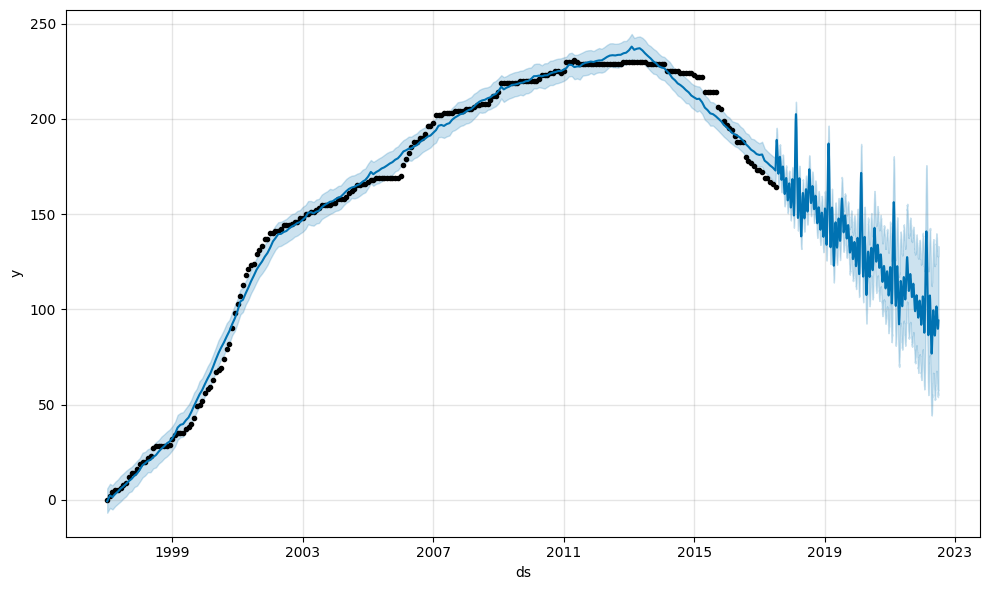

In [ ]:
# Plotagem da previsão
model_retirement.plot(previsao);

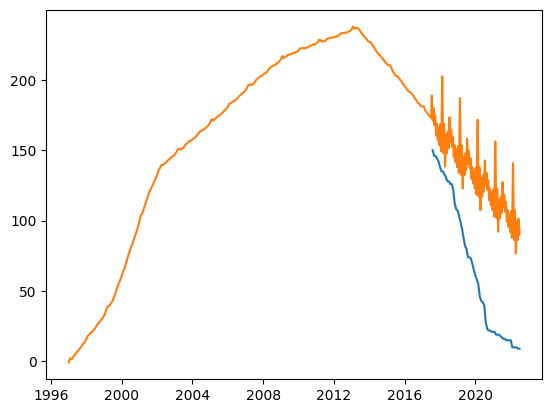

In [ ]:
# Comparação entre resultado e verdadeiro

plt.plot(test['ds'], test['y'])
plt.plot(previsao['ds'], previsao['yhat'])

#### Segundo teste

In [ ]:
# Modela da mesma forma que o anterior
# A predição é em cima do conjunto de teste direto

model_retirement = Prophet()
model_retirement.fit(train)
y_pred = model_retirement.predict(test)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_93o9jng/xkt1bnr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_93o9jng/ka6bnatt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97270', 'data', 'file=/tmp/tmp_93o9jng/xkt1bnr7.json', 'init=/tmp/tmp_93o9jng/ka6bnatt.json', 'output', 'file=/tmp/tmp_93o9jng/prophet_model7vkjxjdq/prophet_model-20230815103039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


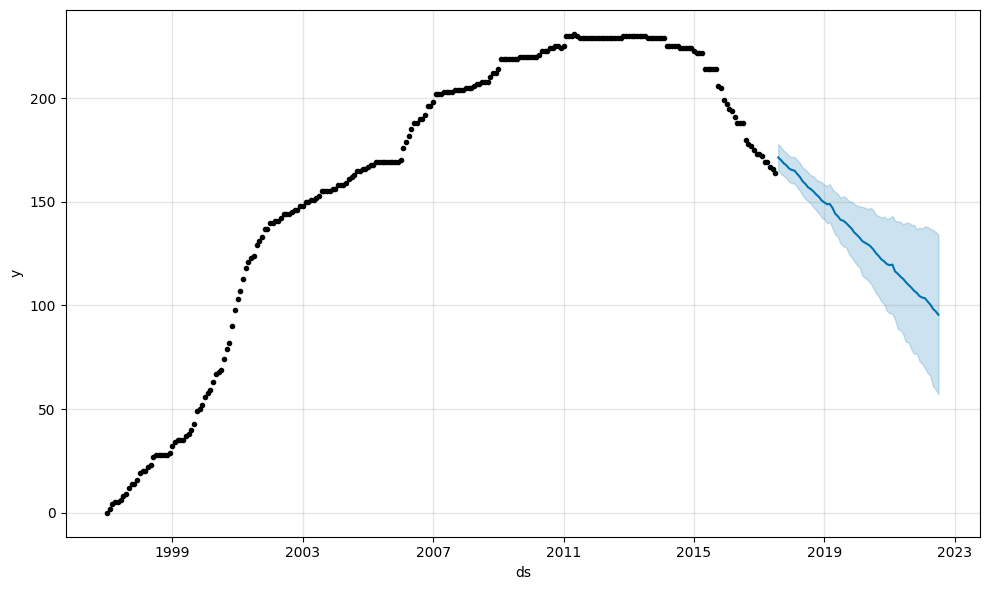

In [ ]:
# Plotagem do resultado
model_retirement.plot(y_pred);

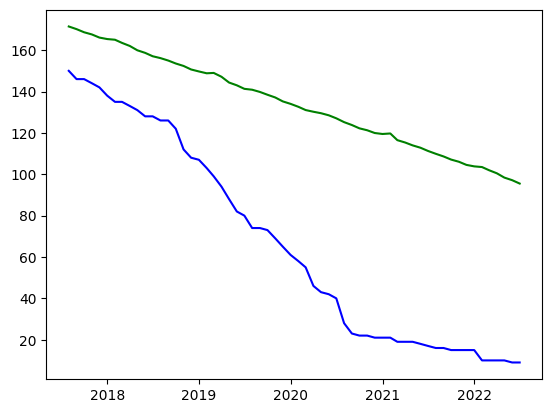

In [ ]:
# Comparação entre os o real e o predito

plt.plot(test['ds'], test['y'], color='blue', label='real')
plt.plot(y_pred['ds'], y_pred['yhat'], color='green', label='predito')

<Axes: xlabel='ds'>

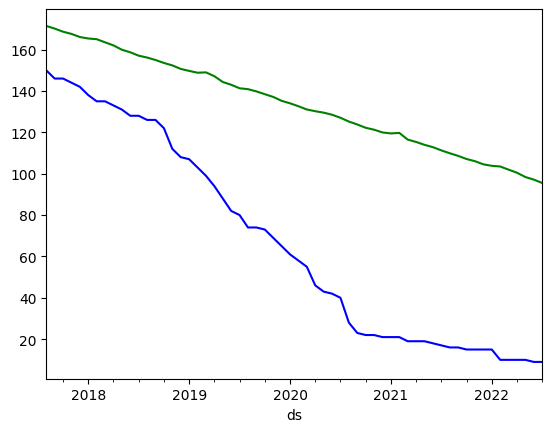

In [ ]:
y_pred.set_index('ds')['yhat'].plot(color='green',label='real')
test.set_index('ds')['y'].plot(color='blue', label='real')

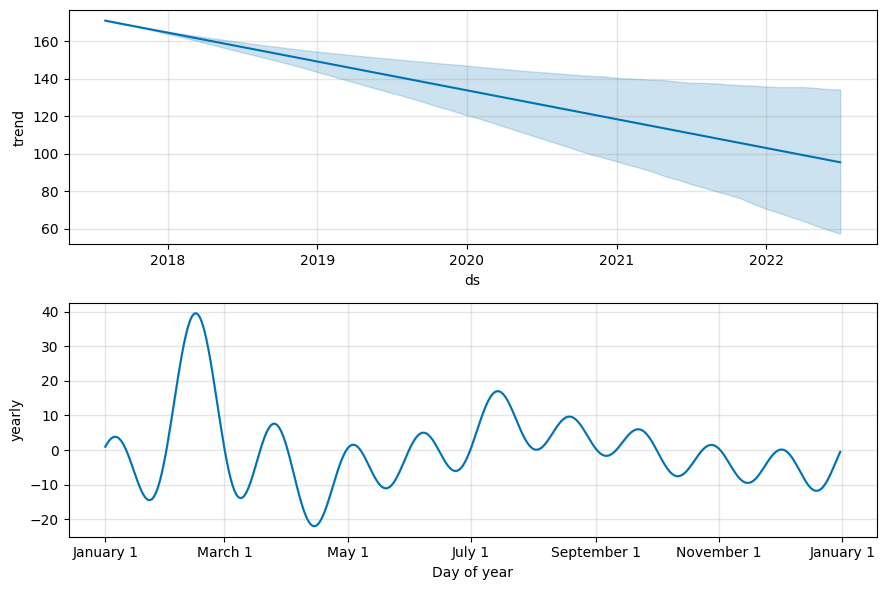

In [ ]:
# Visualização da tendencia da série temporal
components = model_retirement.plot_components(y_pred)
components;